image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (np.float64(-3.16), np.float64(3.16)) arcsec
y range    : (np.float64(-3.16), np.float64(3.16)) arcsec


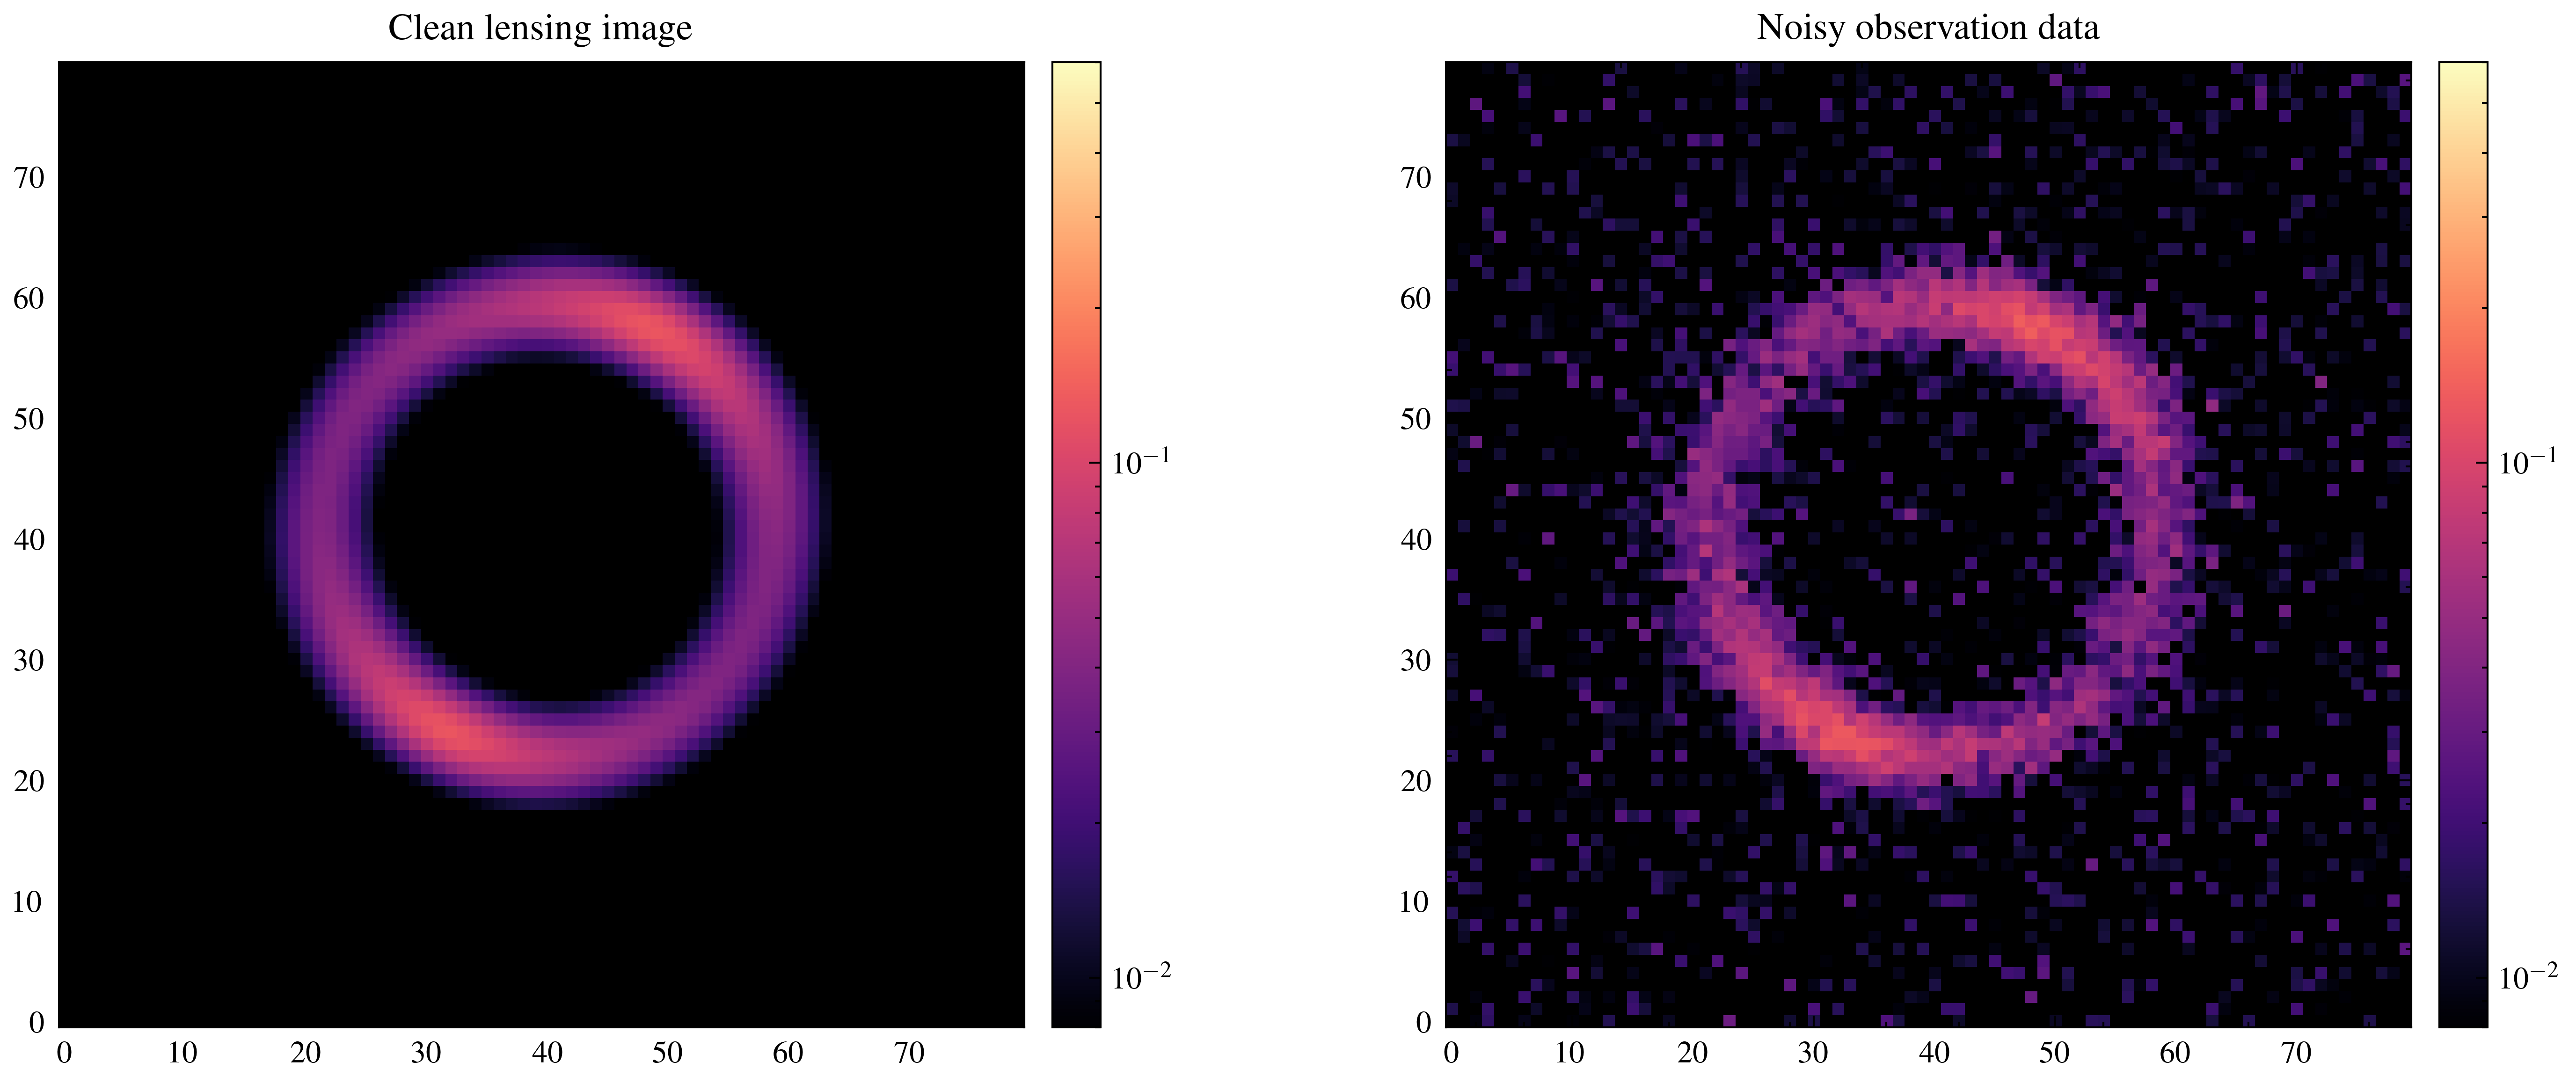

In [ ]:
import sys
    
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
import numpy as np
from copy import deepcopy
import time
from functools import partial
import corner
from pprint import pprint
import pickle as pkl

# probabilistic model
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints

# variational inference
import optax  # optimizers
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal, AutoBNAFNormal

# JAX
import jax
jax.config.update("jax_enable_x64", True)  # comment for single precision
import jax.numpy as jnp

# NUTS Hamiltonian MC sampling
import blackjax

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.Inference.loss import Loss
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.jaxopt import JaxoptOptimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

SAVE_SAMPLES_TO_DISK = False
LOAD_SAMPLES_FROM_DISK = False  # ATTENTION: if True, will overwrite the samples by the ones from the pickled file

SEED = 87651  # fixes the stochasticity

npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pix_scl)

background_rms_simu = 1e-2
exposure_time_simu = 1e3
noise_simu = Noise(npix, npix, background_rms=background_rms_simu, exposure_time=exposure_time_simu)
noise = Noise(npix, npix, exposure_time=exposure_time_simu)  # we will sample background_rms

# Lens mass
lens_mass_model_input = MassModel(['SIS'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
kwargs_lens_input = [{'theta_E': 1.5, 'center_x': cx0, 'center_y': cy0}]


# Lens light
#lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
#kwargs_lens_light_input = [
#    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
#]
#pprint(kwargs_lens_light_input)

# Source light
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.1}
]

# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise_simu,
                         lens_mass_model_class=lens_mass_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=None,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=None)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
key, key_sim = jax.random.split(jax.random.PRNGKey(SEED))
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_sim)

# Plotting engine
plotter = Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

Figure Caption: This figure illustrates the clean lensing image generated using a Singular Isothermal Sphere (SIS) lens model. The lens has an Einstein radius of 1.5 arcseconds and is centered at (0, 0) arcseconds. The source behind the lens is modeled with a Sersic profile, characterized by an amplitude of 4.0, a radius of 0.2 arcseconds, and a Sersic index of 2.0. The source is centered at (0.05, 0.1) arcseconds with ellipticity parameters (0.05, 0.05). This visualization highlights the lensing effect and the clean image produced without noise.


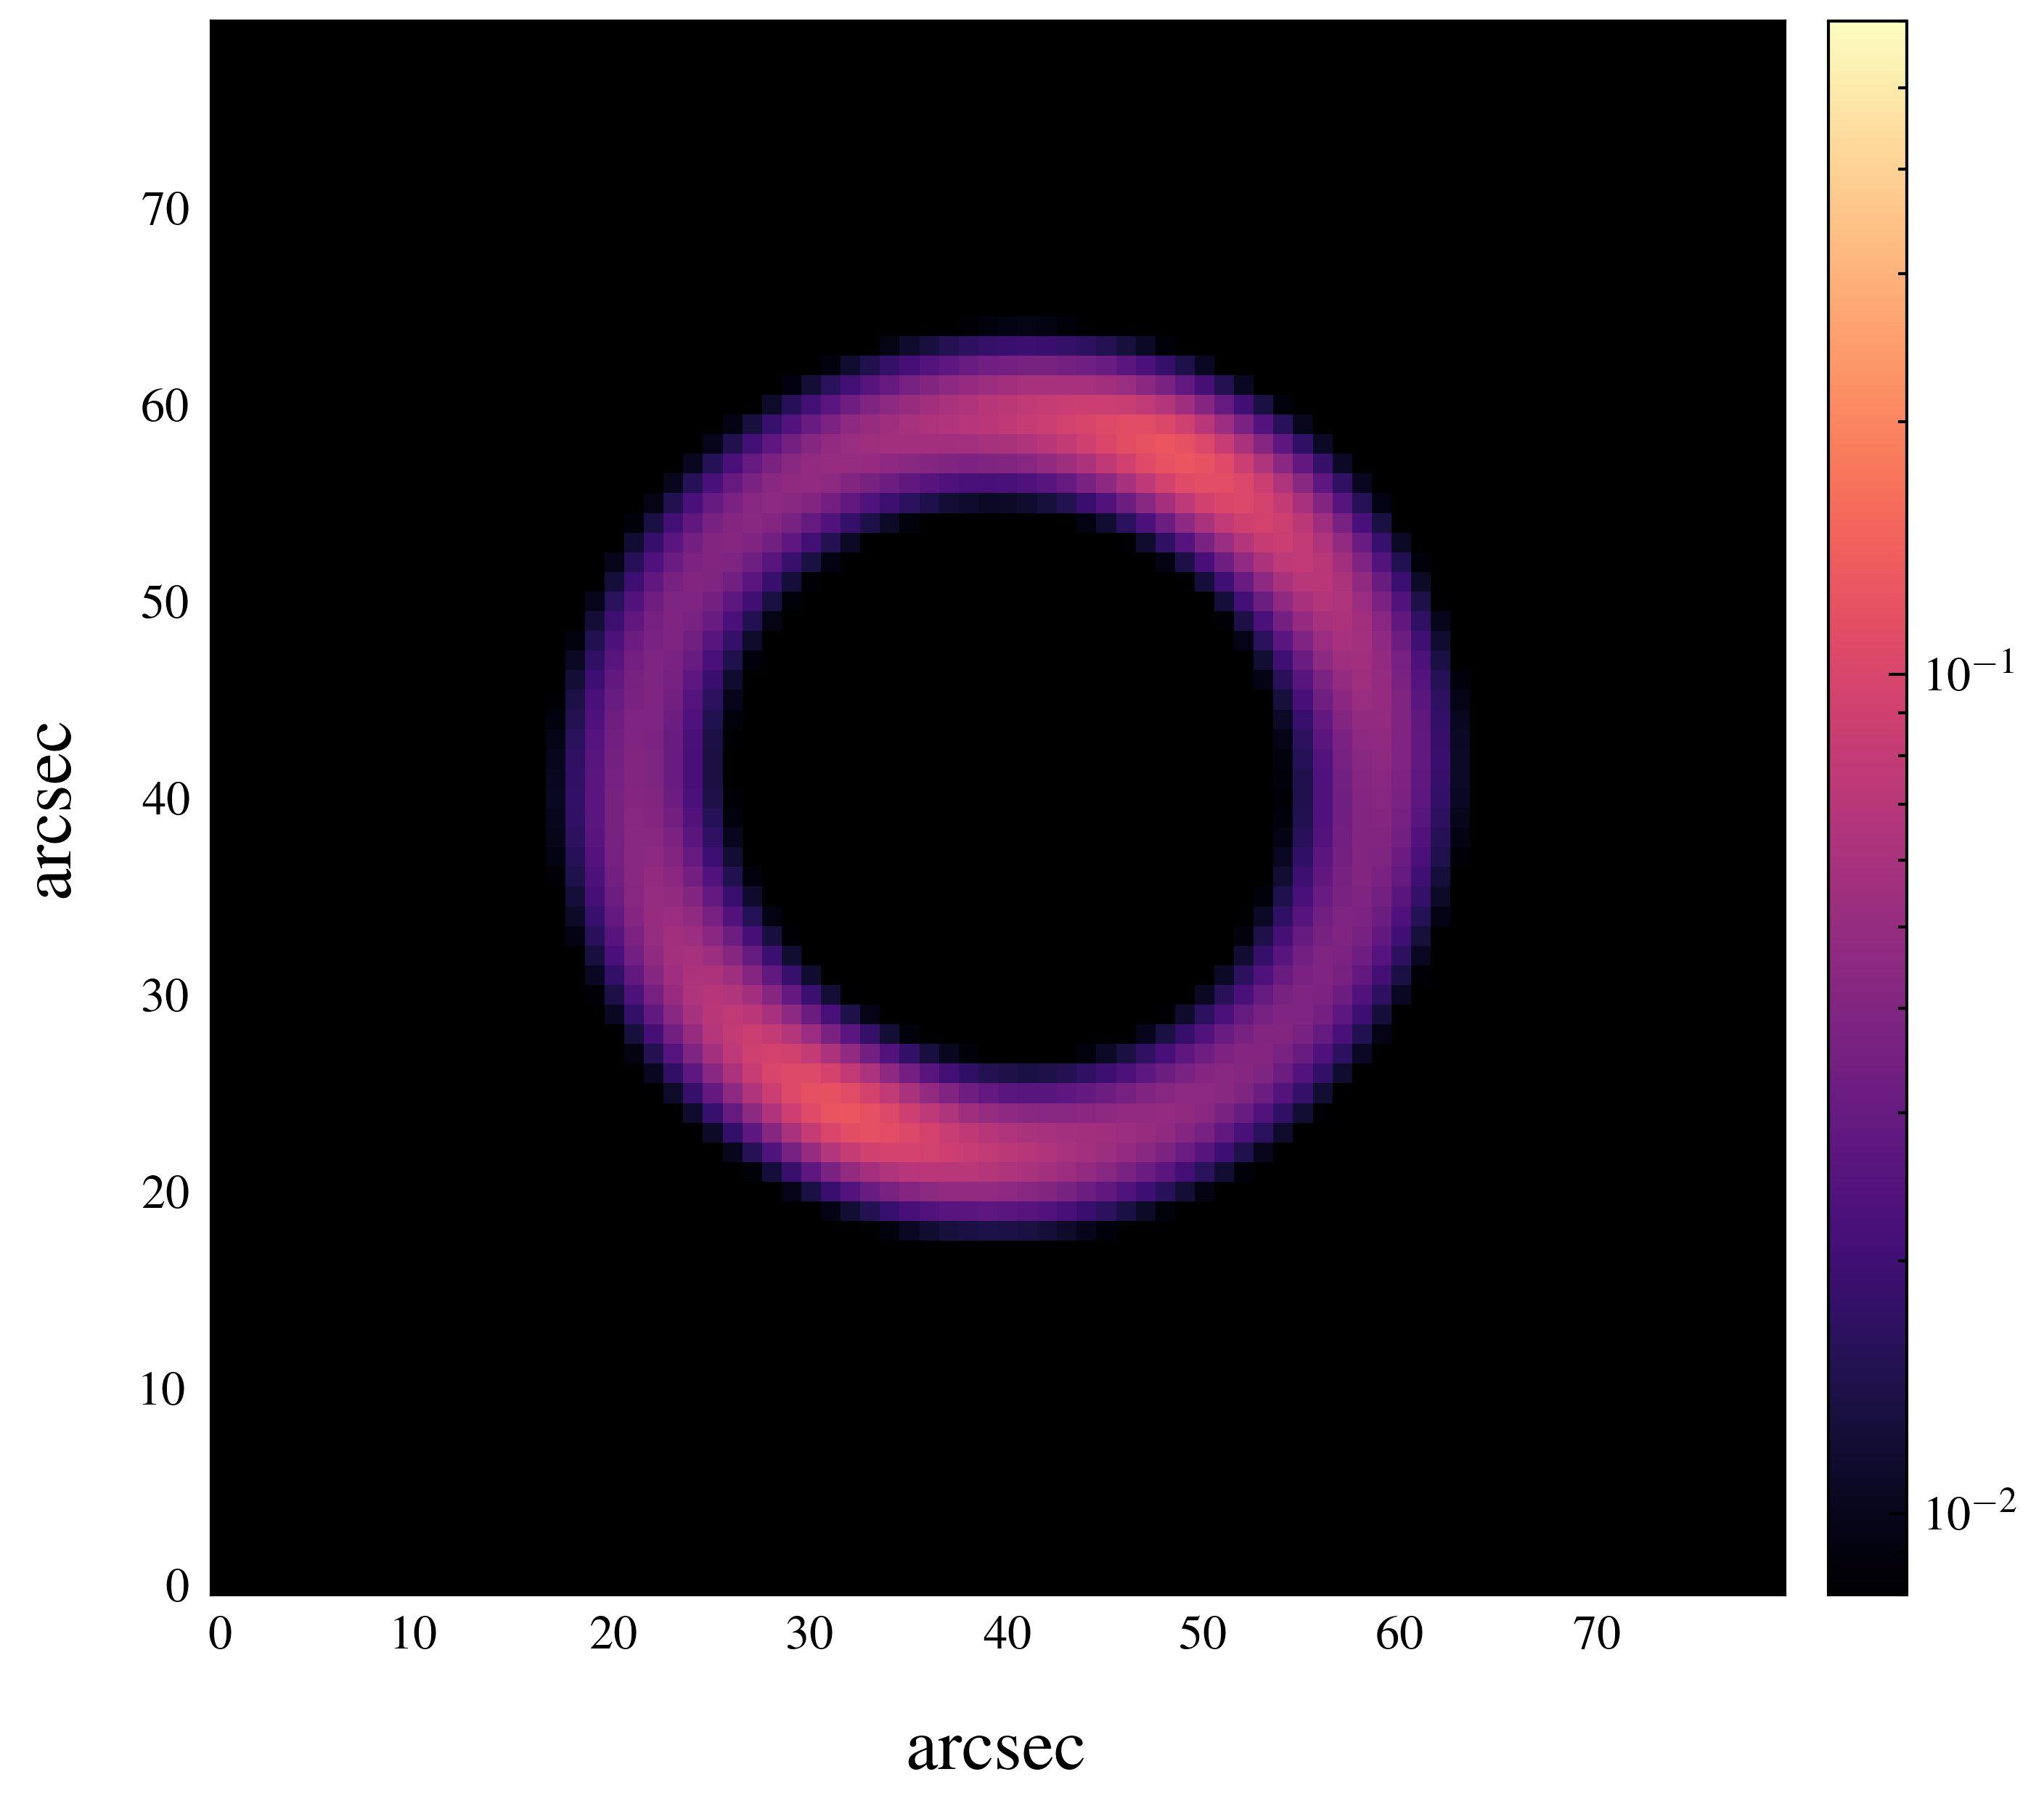

In [18]:
import scienceplots
plt.style.use(['science','ieee'])

# Plotting engine
plotter = Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

# visualize simulated products
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
# ax1.set_title("Clean lensing image")
fig.tight_layout()

# plt.xlabel("arcsec")
# plt.ylabel("arcsec")

# Annotate x-label and y-label using annotation
ax1.annotate("arcsec", xy=(0.5, -0.1), xycoords='axes fraction', ha='center', va='center', fontsize=12)
ax1.annotate("arcsec", xy=(-0.1, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=12, rotation=90)
# Annotate colorbar
ax1.annotate("Flux", xy=(1.05, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=12, rotation=90)

plt.savefig("clean_lensing_image.pdf", bbox_inches='tight')

print("Figure Caption: This figure illustrates the clean lensing image generated using a Singular Isothermal Sphere (SIS) lens model. The lens has an Einstein radius of 1.5 arcseconds and is centered at (0, 0) arcseconds. The source behind the lens is modeled with a Sersic profile, characterized by an amplitude of 4.0, a radius of 0.2 arcseconds, and a Sersic index of 2.0. The source is centered at (0.05, 0.1) arcseconds with ellipticity parameters (0.05, 0.05). This visualization highlights the lensing effect and the clean image produced without noise.")

plt.show()